## Ensemble : Boosting

### 1. 환경준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import * 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings(action='ignore')

### 2. 데이터 준비

* 변수설명
    * COLLEGE : 대학 졸업여부
    * INCOME : 연수입
    * OVERAGE : 월평균 초과사용 시간(분)
    * LEFTOVER : 월평균 잔여시간비율(%)
    * HOUSE : 집값
    * HANDSET_PRICE : 스마트폰 가격
    * OVER_15MINS_CALLS_PER_MONTH : 월평균 장기통화(15분이상) 횟수
    * AVERAGE_CALL_DURATION : 평균 통화 시간
    * REPORTED_SATISFACTION : 만족도 설문조사 결과
    * REPORTED_USAGE_LEVEL : 사용도 자가진단 결과
    * CONSIDERING_CHANGE_OF_PLAN : 향후 변경계획 설문조사 결과
    * CHURN : 이탈(번호이동) 여부 (1-이탈, 0-잔류, Target 변수)

In [2]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data = data.sample(5000, random_state = 2022)
data['CHURN'] = data['CHURN'].map({'LEAVE':1, 'STAY':0})
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
3178,3179,0,119512,51,31,248566,229,5,2,very_sat,very_high,considering,1
14926,14927,1,142144,192,15,774317,581,29,4,unsat,very_little,never_thought,1
15116,15117,1,142308,0,79,306426,497,1,1,sat,little,considering,0
12733,12734,1,113385,0,0,333599,819,1,6,very_unsat,very_high,considering,1
14032,14033,1,90348,209,10,637286,360,26,4,unsat,little,actively_looking_into_it,0


In [3]:
# id drop
drop_cols = ['id']
data.drop(drop_cols, axis = 1, inplace = True )

In [4]:
# x, y 나누기
target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [ ]:
# NA 조치

In [5]:
# 가변수화
cat_cols = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns = cat_cols, drop_first = True)

In [7]:
# train, valid 나누기
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state = 2022)

### 3. 모델링 : XGB

In [8]:
# 모델 선언
model = XGBClassifier(n_estimators = 5, max_depth = 3)

In [9]:
# 학습
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=5, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [10]:
# 예측
pred = model.predict(x_val)

In [11]:
# 평가
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72       769
           1       0.70      0.69      0.70       731

    accuracy                           0.71      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.71      0.71      0.71      1500



### 4. 시각화와 변수 중요도

#### (1) 모델 시각화

- xgboost 자체 plot_tree함수를 제공
- plot_tree (model, num_trees=0)

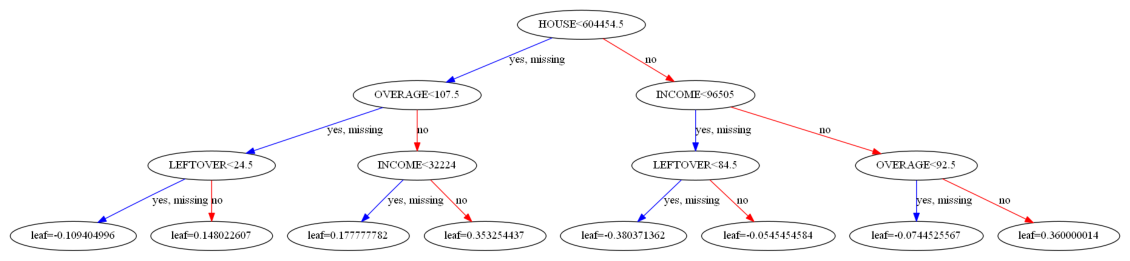

In [12]:
plt.rcParams['figure.figsize'] = 20,20
plot_tree(model, num_trees = 0)
plt.show()

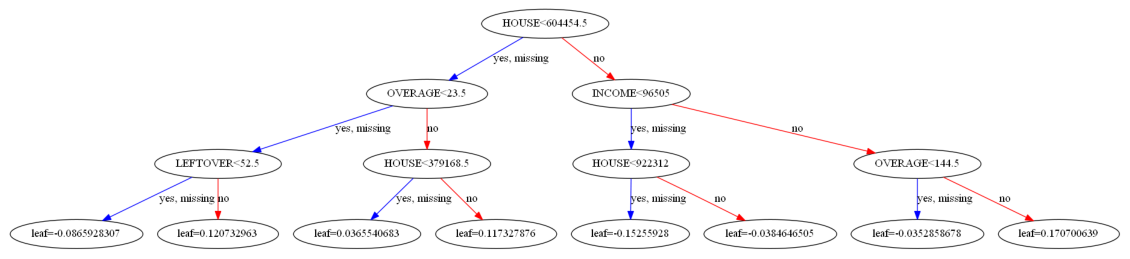

In [13]:
plot_tree(model, num_trees = 4)
plt.show()

#### (2) 변수 중요도

In [14]:
print(x_train.columns)
print(model.feature_importances_)

Index(['COLLEGE', 'INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE',
       'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION',
       'REPORTED_SATISFACTION_sat', 'REPORTED_SATISFACTION_unsat',
       'REPORTED_SATISFACTION_very_sat', 'REPORTED_SATISFACTION_very_unsat',
       'REPORTED_USAGE_LEVEL_high', 'REPORTED_USAGE_LEVEL_little',
       'REPORTED_USAGE_LEVEL_very_high', 'REPORTED_USAGE_LEVEL_very_little',
       'CONSIDERING_CHANGE_OF_PLAN_considering',
       'CONSIDERING_CHANGE_OF_PLAN_never_thought',
       'CONSIDERING_CHANGE_OF_PLAN_no', 'CONSIDERING_CHANGE_OF_PLAN_perhaps'],
      dtype='object')
[0.         0.23316367 0.23149604 0.18991315 0.28209737 0.
 0.06332982 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [15]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

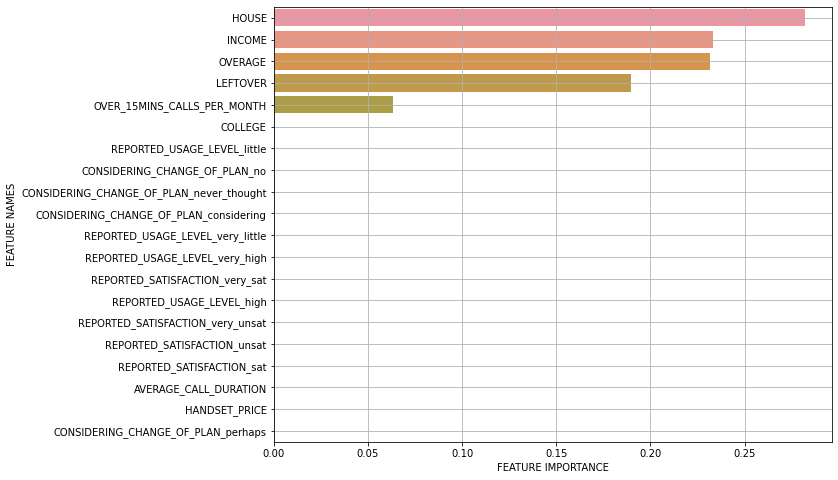

In [16]:
result = plot_feature_importance(model.feature_importances_, x_train.columns)

### 5. 튜닝

- xgboost에 대해 grid search로 튜닝
    - cv=5
    - grid 파라미터
        - max_depth : 3 ~ 8 사이
        - n_estimators : 50 ~ 150 사이
        - learning_rate : 0.01 ~ 0.2 사이

In [17]:
params = {
    'max_depth': range(3, 8, 2),
    'n_estimators': range(50, 151, 50),
    'learning_rate': [0.01, 0.02, 0.03],
}

In [18]:
model = XGBClassifier()
model_gb = GridSearchCV(model, params, cv=5)
model_gb.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [19]:
model_gb.best_params_, model_gb.best_score_

({'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100},
 0.6914285714285715)

In [20]:
pred = model_gb.predict(x_val)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[551 218]
 [220 511]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.72       769
           1       0.70      0.70      0.70       731

    accuracy                           0.71      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.71      0.71      0.71      1500



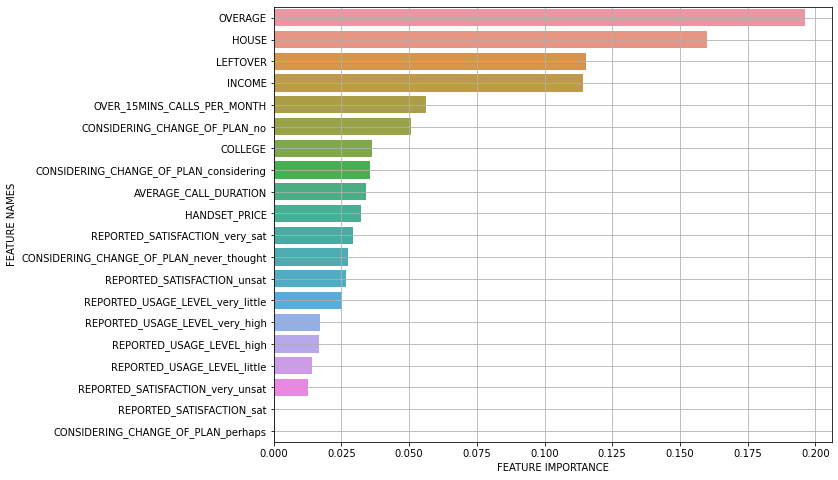

In [21]:
result = plot_feature_importance(model_gb.best_estimator_.feature_importances_, list(x_train))

### 6. 하이퍼파라미터 변화에 따른 성능 추세

#### (1) n_estimators

In [22]:
grid_param = {'n_estimators':range(1,200,2)}
model = XGBClassifier()
model_gs = GridSearchCV(model, grid_param, cv = 3)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [23]:
result = pd.DataFrame(model_gs.cv_results_)

In [24]:
temp = result.loc[:, ['param_n_estimators','mean_test_score']]
temp.head()

,param_n_estimators,mean_test_score
0,1,0.661712
1,3,0.674854
2,5,0.674856
3,7,0.672855
4,9,0.671428


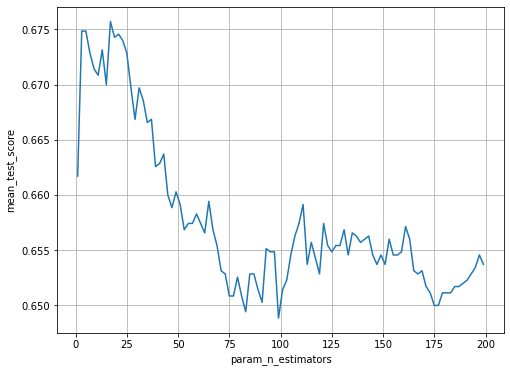

In [25]:
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_n_estimators', y = 'mean_test_score', data = temp )
plt.grid()
plt.show()

- 트리의 개수가 많아지게 되면 성능이 떨어진다.
- 트리가 많을수록 y_train과의 성능이 줄어든다.
    - 과적합이 발생한다.

#### (2) learning rate

In [26]:
grid_param = {'learning_rate':np.linspace(0.005, 0.01, 50)}
model = XGBClassifier()
model_gs = GridSearchCV(model, grid_param, cv = 3)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
       0.00653061, 0.00663265, 0.00673469, 0.00683673, 0.00693878,
       0.00704082, 0.00714286, 0.0072449 , 0.00734694, 0.00744898,
       0.00755102, 0.00765306, 0.0077551 , 0.00785714, 0.00795918,
       0.00806122, 0.00816327, 0.00826531, 0.

In [27]:
result = pd.DataFrame(model_gs.cv_results_)

In [28]:
temp = result.loc[:, ['param_learning_rate','mean_test_score']]
temp.head()

,param_learning_rate,mean_test_score
0,0.005,0.682284
1,0.005102,0.683999
2,0.005204,0.683713
3,0.005306,0.684570
4,0.005408,0.684570


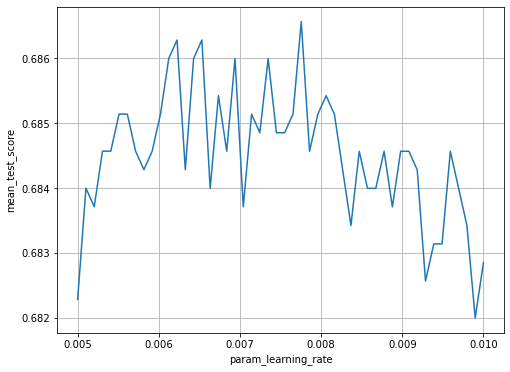

In [29]:
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_learning_rate', y = 'mean_test_score', data = temp )
plt.grid()
plt.show()

- 갈수록 score가 떨어지는 추세

#### (3) n_estimators + learning rate

In [30]:
grid_param = {'learning_rate':np.linspace(0.001,0.3,50),
              'n_estimators':[20,30,50,100]}
model = XGBClassifier(eval_metric = 'logloss')
model_gs = GridSearchCV(model, grid_param, cv = 5)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     m...
       0.12304082, 0.12914286, 0.1352449 , 0.14134694, 0.14744898,
       0.15355102, 0.15965306, 0.1657551 , 0.17185714, 0.17795918,
       0.18406122, 0.19016327, 0.19626531, 0.20236735, 0.20846939,
       0

In [31]:
result = pd.DataFrame(model_gs.cv_results_)

In [32]:
temp = result.loc[:, ['param_n_estimators', 'param_learning_rate','mean_test_score']]
temp.head()

,param_n_estimators,param_learning_rate,mean_test_score
0,20,0.001,0.681143
1,30,0.001,0.680571
2,50,0.001,0.681143
3,100,0.001,0.681714
4,20,0.007102,0.687429


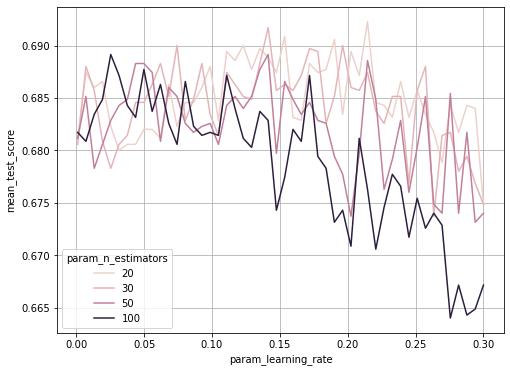

In [33]:
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_learning_rate', y = 'mean_test_score', data = temp, hue = 'param_n_estimators')
plt.grid()
plt.show()